![](img/solar_logo.png)
# Lecture 1: Clustering of sequential data in education

Quan Nguyen, Department of Statistics, University of British Columbia

## Learning objectives:

By the end of this lecture, workshop participants should be able to:

- Understand the type of questions that are relevant to clustering of sequential data
- Understand different types of sequence data format and convert between formats
- Create a sequence object from an existing dataset using the `TraMineR` package
- Manipulate sequence object to deal with missing values and misaligned sequences
- Visualize and compute descriptive statitsics to explore sequential data

## 1. Why do we want to perform cluster analysis on sequential data in education?

### What types of temporal/sequential data exist in education?

| Data source   | Time granularity             | Questions                                                                             |
|---------------|------------------------------|---------------------------------------------------------------------------------------|
| SIS records   | Semester/Year                | What are the common study paths taken by students based on their course enrolment?    |
| LMS log files | Seconds/Daily/Semester       | What are the common learning patterns of students during a course?                    |
| Eye-tracking  | Miliseconds/Seconds/Minutes  | What are the common thought process when students engage in an exercise?              |
| Videos        | Frames/Seconds/Minutes       | What are the common interaction patterns of students during collaborative activities? |                                                                                       |
|               |                              |                                                                                       |
|               |                              |                                                                                       |

### What type of research questions that are temporal/sequential specific?

- Exploratory: What are the common patterns exist in the data? 
- Predictive: Can we classifiy an existing sequence? Can we predict the next activity/outcome given a sequence?
- Causal: Does X cause Y?

### Introduction to the TramineR package

TraMineR is a R-package for mining, describing and visualizing sequences of states or events, and more generally discrete sequence data
- [Reference manual here](https://cran.r-project.org/web/packages/TraMineR/TraMineR.pdf)
- [Tutorial here](http://mephisto.unige.ch/pub/TraMineR/doc/TraMineR-Users-Guide.pdf)
- [Example here](http://traminer.unige.ch/preview-main.shtml)

Some common usage of TramineR includes:
- Visualize sequences
- Explore sequences with descriptive statistics (e.g., frequencies, transitional probabilities, entropy)
- Cluster analysis of sequences (e.g., Optimal matching/Edit distances)
- Run discrepancy analyses to study how sequences are related to covariates

Installation in R: 

```sh
install.packages("TraMineR", dependencies=TRUE)
```



In [1]:
# install.packages("TraMineR")
library("TraMineR")
packageVersion("TraMineR")
library(readr)
library(tidyverse)

Warning message:
“package ‘TraMineR’ was built under R version 4.1.1”

TraMineR stable version 2.2-3 (Built: 2022-01-26)

Website: http://traminer.unige.ch

Please type 'citation("TraMineR")' for citation information.




[1] ‘2.2.3’

Warning message:
“package ‘readr’ was built under R version 4.1.1”
── Attaching packages ────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ dplyr   1.0.7
✔ tibble  3.1.5     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ purrr   0.3.4     

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Some terminologies

#### States vs events

- States: Read, write, discuss, review  
- Events: Read -> Write, Write -> Discuss (each change of state is an event)

As see in the example below, the sequences 7,8,9,10 no event occurred during the observation period since the respondent stays in the same state during the whole sequence

In sequence 2, two events occurred: `Practice -> Read`, and `Read -> Practice`

 [>] 4 distinct states appear in the data: 

     1 = Discuss

     2 = Practice

     3 = Read

     4 = Watch

 [>] state coding:

       [alphabet]  [label]  [long label] 

     1  Discuss     Discuss  Discuss

     2  Practice    Practice Practice

     3  Read        Read     Read

     4  Watch       Watch    Watch

 [>] 2000 sequences in the data set

 [>] min/max sequence length: 12/12



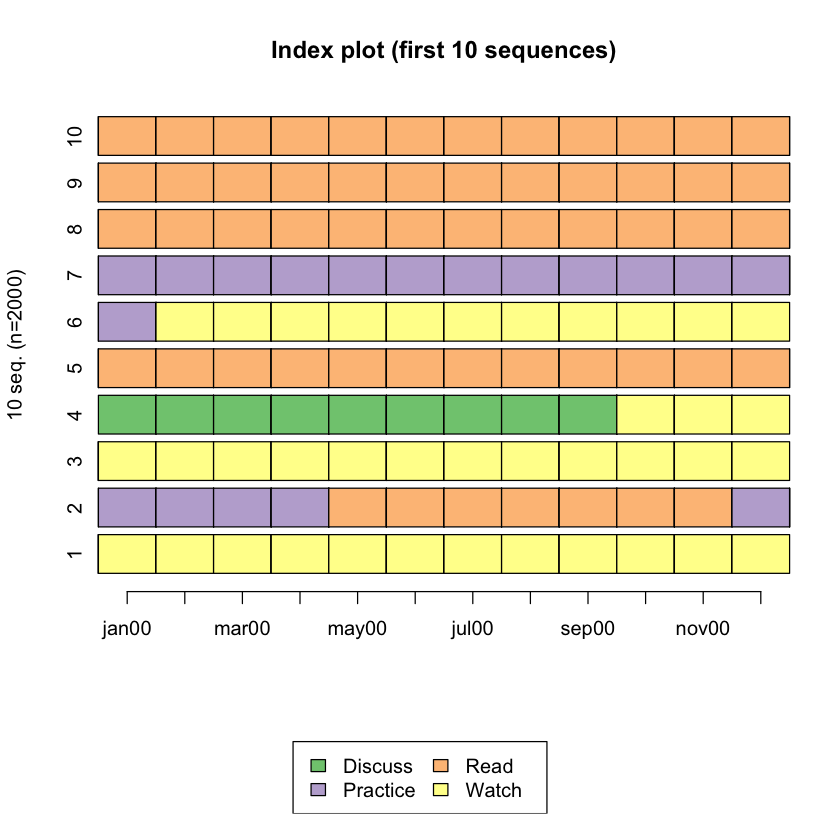

In [2]:
# options(warn=-1)
data(actcal)
actcal <- data.frame(lapply(actcal, function(x) { gsub("^A\\b", "Read", x)}))
actcal <- data.frame(lapply(actcal, function(x) { gsub("^B\\b", "Watch", x)}))
actcal <- data.frame(lapply(actcal, function(x) { gsub("^C\\b", "Discuss", x)}))
actcal <- data.frame(lapply(actcal, function(x) { gsub("^D\\b", "Practice", x)}))
actcal.seq <- seqdef(actcal, var = 13:24)
# actcal.seq
seqiplot(actcal.seq, main = "Index plot (first 10 sequences)",with.legend = TRUE)

The **alphabet** is the number of unique states (or events) in the data. In the example above, we have four unique states (i.e., Read, Discuss, Practice, Watch) so the **alphabet** = 4



In [3]:
alphabet(actcal.seq)

[1] "Discuss"  "Practice" "Read"     "Watch"

**Time reference: Internal and external clocks**

- Internal: Year 1, Year 2, Year 3 or Semester 1, Semester 2, Semester 3
- External: June 17th, 2022, or 14:30:00 PST

## 2. Data manipulation with sequences

### Data format

#### The ‘states-sequence’ (STS) format
- Each row is an individual
- In this format, the successive states (statuses) of an individual are given in consecutive columns. Each column is supposed to correspond to a predetermined time unit

In [4]:
head(actcal.seq)

,jan00,feb00,mar00,apr00,may00,jun00,jul00,aug00,sep00,oct00,nov00,dec00
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch
2,Practice,Practice,Practice,Practice,Read,Read,Read,Read,Read,Read,Read,Practice
3,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch
4,Discuss,Discuss,Discuss,Discuss,Discuss,Discuss,Discuss,Discuss,Discuss,Watch,Watch,Watch
5,Read,Read,Read,Read,Read,Read,Read,Read,Read,Read,Read,Read
6,Practice,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch


#### The ‘state-permanence-sequence’ (SPS) format
- Each row is an individual
- Each successive distinct state in the sequence is given together with its duration

In [5]:
# print(head(actcal.seq), format='SPS')
actcal.sps <- seqformat(actcal, 13:24, from = "STS", to = "SPS", compress = TRUE)
head(actcal.sps)

 [>] converting STS sequences to 2000 SPS sequences

 [>] compressing SPS sequences



,Sequence
1,"(Watch,12)"
2,"(Practice,4)-(Read,7)-(Practice,1)"
3,"(Watch,12)"
4,"(Discuss,9)-(Watch,3)"
5,"(Read,12)"
6,"(Practice,1)-(Watch,11)"


#### The vertical ‘time-stamped-event’ (TSE) format
- Each row is an **event**
- Each record of the TSE representation usually contains a case identifier, a time stamp and codes identifying the event occurring

In [6]:
tstate <- seqetm(actcal.seq, method='state')
actcal.tse <- seqformat(actcal, 13:24, from = "STS", to = "TSE", tevent=tstate)
head(actcal.tse)

 [!!] 'id' set to NULL as it is not specified (backward compatibility with TraMineR 1.8)

 [!!] replacing original IDs in the output by the sequence indexes

 [>] converting STS sequences to 2579 TSE sequences



,id,time,event
,<dbl>,<dbl>,<chr>
1,1,0,Watch
2,2,0,Practice
3,2,4,Read
4,2,11,Practice
5,3,0,Watch
6,4,0,Discuss


### The spell (SPELL) format
- Each row is a **state**
- Each record of SPELL contains an ID, start time, end time, and the state

In [7]:
actcal.spell <- seqformat(actcal, 13:24, from = "STS", to = "SPELL")
head(actcal.spell)

 [>] converting STS sequences to 2579 spells



,id,begin,end,states
,<chr>,<dbl>,<dbl>,<fct>
1,1,1,12,Watch
2,2,1,4,Practice
3,2,5,11,Read
4,2,12,12,Practice
5,3,1,12,Watch
6,4,1,9,Discuss


### Converting between format

```sh
seqformat(data, var = ..., from = "...", to = ",,,", compress = FALSE/TRUE)
```

Examples: 
- `seqformat(actcal, 13:24, from = "STS", to = "SPELL")`
- `seqformat(actcal, 13:24, from = "STS", to = "SPS", compress = TRUE)`

### Create a sequence object from data

We can use the `seqdef` function to create a sequence object from an existing dataframe.

In the dataset `actcal` below, it consists of:
- The sequence data were collected on a monthly basis on each participant in columns: "jan00", "feb00", "mar00", "apr00", "may00", "jun00", "jul00", "aug00", "sep00", "oct00", "nov00", "dec00"
- The covariates such as age, education, region, etc...

In [8]:
head(actcal)

,idhous00,age00,educat00,civsta00,nbadul00,nbkid00,aoldki00,ayouki00,region00,com2.00,⋯,mar00,apr00,may00,jun00,jul00,aug00,sep00,oct00,nov00,dec00
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,60671,47,maturity,married,3,2,17,14,"Middleland (BE, FR, SO, NE, JU)",Industrial and tertiary sector communes,⋯,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch
2,25321,21,maturity,"single, never married",2,0,-3,-3,Zurich,Suburban communes,⋯,Practice,Practice,Read,Read,Read,Read,Read,Read,Read,Practice
3,53221,50,full-time vocational school,married,2,0,-3,-3,"Lake Geneva (VD, VS, GE)",Peripheral urban communes,⋯,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch
4,13911,37,maturity,"single, never married",1,0,-3,-3,"Middleland (BE, FR, SO, NE, JU)",Centres,⋯,Discuss,Discuss,Discuss,Discuss,Discuss,Discuss,Discuss,Watch,Watch,Watch
5,145301,20,apprenticeship,"single, never married",3,0,-3,-3,"North-west Switzerland (BS, BL, AG)",Rural commuter communes,⋯,Read,Read,Read,Read,Read,Read,Read,Read,Read,Read
6,40022,27,"university, higher specialized school","single, never married",2,0,-3,-3,"Central Switzerland (LU, UR, SZ, OW, NW, ZG)",Suburban communes,⋯,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch,Watch


To create the sequence, we can use the `seqdef()` function. 

We can see that there were 2000 sequences, with the length of 12, and consists of 4 states

In [9]:
actcal.seq <- seqdef(actcal, var = c("jan00", "feb00", "mar00",
         "apr00", "may00", "jun00", "jul00", "aug00", "sep00", "oct00",
         "nov00", "dec00"))

 [>] 4 distinct states appear in the data: 

     1 = Discuss

     2 = Practice

     3 = Read

     4 = Watch

 [>] state coding:

       [alphabet]  [label]  [long label] 

     1  Discuss     Discuss  Discuss

     2  Practice    Practice Practice

     3  Read        Read     Read

     4  Watch       Watch    Watch

 [>] 2000 sequences in the data set

 [>] min/max sequence length: 12/12



But this is a relatively clean data set, because it has defined a time unit (monthly). There were also no missing value or no misalignment in the timing of data collection (everyone started and ended at the same time).

**Import a log file**

Let's try to process a more messy example of a log file `lasi21_logdata.csv`. The dataset consists of 852,458 records and 9 columns
* `id` refers to anonymized student ID
* `sas_id_site` refers to the id of the site that students visited
* `site_type` refers to the type of content (e.g., resource, homepage, forumng, ...)
* `date_time` referes to the timestamp
* `spent_time` refers to the estimated dwell time in miliseconds
* `action` refers to the type of action took place (e.g., view, download, etc..)
* `instancename` refers to the type of content (e.g., chapter 1, chapter 2, assignment 1, etc..)
* `avg score` refers to the final score
* `PassFlag` refers to a binary class of whether students passed or failed the course

In [10]:

lasi21_logdata <- read_csv("~/Downloads/lasi21_logdata.csv")

Rows: 852458 Columns: 9

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): site_type, action, instancename
dbl  (5): id, sas_id_site, spent_time, avg score, PassFlag
dttm (1): date_time


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [11]:
# Fixing some typos
lasi21_logdata$site_type <- ifelse(grepl("ssignment", lasi21_logdata$instancename), "assignment",lasi21_logdata$site_type )
lasi21_logdata$site_type <- ifelse(grepl("exam", lasi21_logdata$instancename), "assignment",lasi21_logdata$site_type )

# Convert dataframe to data.table for faster processing
lasi21_logdata <- lasi21_logdata %>% select(id,date_time,spent_time,site_type)

head(lasi21_logdata)

id,date_time,spent_time,site_type
<dbl>,<dttm>,<dbl>,<chr>
1,2017-01-22 02:16:00,1000,content
1,2017-02-15 14:47:00,12000,content
1,2017-01-22 01:58:00,1000,content
1,2017-01-22 02:16:00,1000,content
1,2016-12-01 20:23:00,58000,studio
1,2017-03-14 14:59:00,2000,forumng


Now we need to make some decisions:

* What is a sequence in our data? (i.e., what each row will represent)
    - Each sequence could be a student
    - Each sequence could be a learning session (defined as consecutive learning activities of at least 60s with no more than 30 minutes break between activities)
    
* What is the time unit in our data?
    - Every minute?
    - Every 5 mins?
    - Every hour?

In [12]:
# convert ms to minutes
lasi21_logdata$spent_time_m <- round(lasi21_logdata$spent_time/60000, digits=1)

# create a flag for session break (aka where time spent > 30 minutes)
lasi21_logdata$session_flag <- 0
lasi21_logdata$session_flag <- ifelse(lasi21_logdata$spent_time_m>30, 1, lasi21_logdata$session_flag)

# filter out all spent_time < 90s
lasi21_logdata2 <- lasi21_logdata %>%  filter(spent_time>=90000)


# create session number 
lasi21_logdata2 <- lasi21_logdata2 %>% 
                        arrange(id,date_time,spent_time) %>% 
                        mutate(session_num = cumsum(session_flag))

# remove session break
lasi21_logdata2 <- lasi21_logdata2 %>%  filter(session_flag==0)

# for each learning session, calculate the cummulative time spent
lasi21_logdata2 <- lasi21_logdata2 %>% 
                        arrange(id,date_time,spent_time) %>% 
                        group_by(session_num) %>% 
                        mutate(spent_time_m_cum = cumsum(spent_time_m))

# create time unit as 1 minute (60s)
lasi21_logdata2$time_unit <- round(lasi21_logdata2$spent_time_m_cum,digits=0)
head(lasi21_logdata2)

id,date_time,spent_time,site_type,spent_time_m,session_flag,session_num,spent_time_m_cum,time_unit
<dbl>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-09-06 18:19:00,217000,content,3.6,0,1,3.6,4
1,2016-09-06 18:22:00,397000,content,6.6,0,1,10.2,10
1,2016-09-06 18:29:00,337000,content,5.6,0,1,15.8,16
1,2016-09-06 18:34:00,182000,content,3.0,0,1,18.8,19
1,2016-09-06 18:38:00,178000,content,3.0,0,1,21.8,22
1,2016-09-07 13:43:00,323000,content,5.4,0,3,5.4,5


**Prepare data in SPELL format**

Since the log data can capture the start time and end time of each visit, it makes it suitable to prepare the data in a SPELL format. 

To recall, the structure of a SPELL data format should look like this

| Position | Varible    | Option name |
|----------|------------|-------------|
| 1        | ID         | id          |
| 2        | Start time | begin       |
| 3        | End time   | end         |
| 4        | Status     | status      |

In [13]:
log_spell <- lasi21_logdata2 %>% 
            group_by(session_num) %>% 
            mutate(start = lag(time_unit), start=replace_na(start,1), end=time_unit) %>% 
            select(session_num,start,end,site_type)
log_spell %>% filter(session_num==22)

session_num,start,end,site_type
<dbl>,<dbl>,<dbl>,<chr>
22,1,19,content
22,19,29,resource
22,29,53,content
22,53,58,content


**Create sequence data from SPELL format**

We can use the `seqdef()` function to convert the SPELL data into STS format, which will be used for subsequent analyses.

Note:
- For some reasons, `seqdef()` does not play well with tibble format or any other formats than data.frame, so make sure to convert your data using the `as.data.frame()` function

In [14]:
log_spell <- as.data.frame(log_spell)
log_spell.seq <- seqdef(log_spell, var = c(id="session_num", begin="start", end="end", status="site_type"), 
                   informat = "SPELL",  process = FALSE)

 [>] time axis: 1 -> 429

 [>] converting SPELL data into 21418 STS sequences (internal format)

 [>] found missing values ('NA') in sequence data

 [>] preparing 21418 sequences

 [>] coding void elements with '%' and missing values with '*'

 [>] 12 distinct states appear in the data: 

     1 = assignment

     2 = collaborate

     3 = content

     4 = forumng

     5 = glossary

     6 = homepage

     7 = questionnaire

     8 = resource

     9 = studio

     10 = subpage

     11 = url

     12 = wiki

 [>] state coding:

       [alphabet]    [label]       [long label] 

     1  assignment    assignment    assignment

     2  collaborate   collaborate   collaborate

     3  content       content       content

     4  forumng       forumng       forumng

     5  glossary      glossary      glossary

     6  homepage      homepage      homepage

     7  questionnaire questionnaire questionnaire

     8  resource      resource      resource

     9  studio        studio        s

What can we observe from the output above?

- There were 21,418 sequences in the data set
- min/max sequence length: 2/429
- 12 distinct states
- coding void elements with '%' and missing values with '*'

In [15]:
head(log_spell.seq)

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,⋯,y420,y421,y422,y423,y424,y425,y426,y427,y428,y429
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,content,content,content,content,content,content,content,content,content,content,⋯,%,%,%,%,%,%,%,%,%,%
3,content,content,content,content,content,content,content,content,content,content,⋯,%,%,%,%,%,%,%,%,%,%
4,content,content,content,content,content,content,content,content,content,content,⋯,%,%,%,%,%,%,%,%,%,%
5,content,content,content,content,content,content,content,content,content,content,⋯,%,%,%,%,%,%,%,%,%,%
8,content,content,%,%,%,%,%,%,%,%,⋯,%,%,%,%,%,%,%,%,%,%
9,forumng,forumng,%,%,%,%,%,%,%,%,⋯,%,%,%,%,%,%,%,%,%,%


We can also print out some sequences using the SPS format for easy observations

In [16]:
print(log_spell.seq[31:41,], format="SPS")

   Sequence                                                                  
45 (assignment,1)-(studio,22)-(assignment,7)-(studio,4)                      
46 (assignment,28)                                                           
48 (forumng,2)                                                               
50 (homepage,4)-(assignment,43)                                              
51 (assignment,8)                                                            
54 (assignment,3)                                                            
55 (homepage,13)-(assignment,8)-(content,3)                                  
56 (assignment,16)                                                           
57 (assignment,14)-(content,28)-(assignment,11)-(resource,18)-(assignment,17)
59 (assignment,19)-(resource,16)-(forumng,2)                                 
61 (content,13)                                                              


Let's plot these example sequences using the `seqiplot()` function

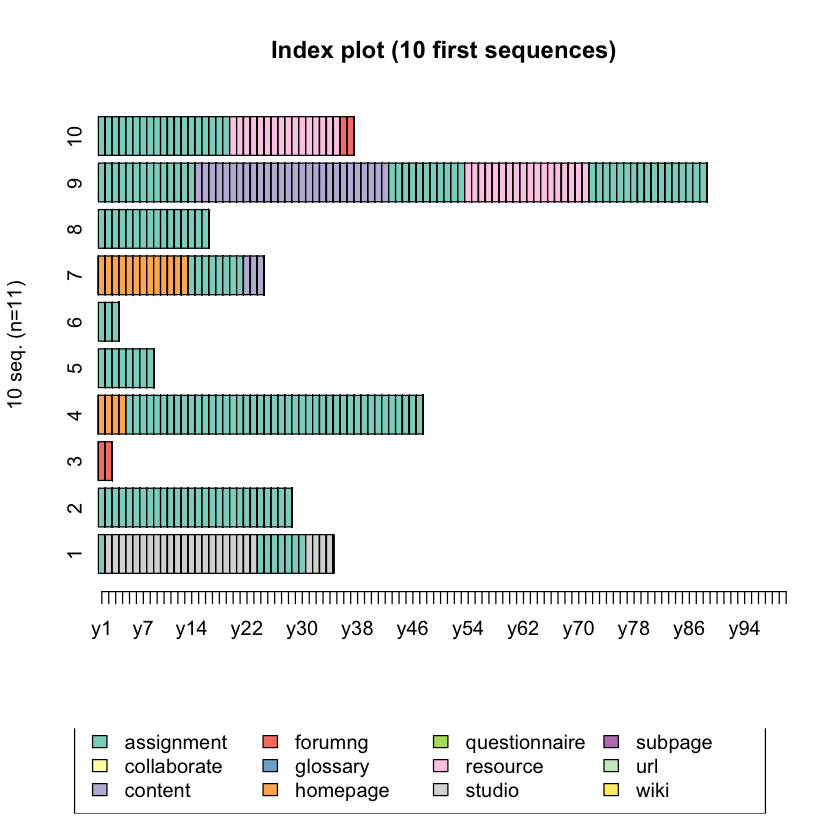

In [17]:
seqiplot(log_spell.seq[31:41,1:100], with.legend = T, main = "Index plot (10 first sequences)")

As a final note, there is not a single approach to pre-process your data. In practice, there are a few 'nobs' that you could adjust when pre-processing your data:
- What is the time granularity of your sequence (e.g., every second, every minute, every 5 mins)
- What is a sequence in your study? (e.g., each person is a sequence, or each learing session - however you define a learning session)
- What is a status? (e.g., read, write, discuss, practice)

### Truncations, gaps and missing values

- Sequences defined as the list of successive states without duration information are typically of varying length.
- In event sequences, the number of events experienced by each individual differs from one individual to the other.
- The length of the follow up is not the same for all individuals or sequences may be right or left censored.
- Sequences may not be left aligned depending on the time axis on which they are defined.
- Data may not be available for all measuring points yielding internal gaps in the sequences.

Let's simulate an example of data when sequences are not aligned. In this example, three sequences (s1,s2,s3) have different start and end date. Participant b also have a gap in 1993. If the respondents entered the study at different points in time and we represent the data on a calendar time axis, the data could look like this

In [18]:
s1 <- c("a","b","c","d",NA,NA)
s2 <- c(NA,"a","b",NA,"c","d")
s3 <- c(NA,NA, "a","b","c","d")

df <- data.frame(rbind(s1,s2,s3))
colnames(df) <- c(1990:1995)
df

,1990,1991,1992,1993,1994,1995
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
s1,a,b,c,d,NA,NA
s2,NA,a,b,NA,c,d
s3,NA,NA,a,b,c,d


Let's create a sequence object from `df`.
The default values of the `seqdef()` function are `left=NA`, `gaps=NA` and `right="DEL"`. We will see what these options mean in a moment

In [19]:
seqdef(df)

 [>] found missing values ('NA') in sequence data

 [>] preparing 3 sequences

 [>] coding void elements with '%' and missing values with '*'

 [>] 4 distinct states appear in the data: 

     1 = a

     2 = b

     3 = c

     4 = d

 [>] state coding:

       [alphabet]  [label]  [long label] 

     1  a           a        a

     2  b           b        b

     3  c           c        c

     4  d           d        d

 [>] 3 sequences in the data set

 [>] min/max sequence length: 4/6



,1990,1991,1992,1993,1994,1995
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
s1,a,b,c,d,%,%
s2,*,a,b,*,c,d
s3,*,*,a,b,c,d


In this case it may be more appropriate to represent the data on a process time axis where all sequences would be left aligned, meaning that their common origin is not a specific year but the beginning of the observed 4 year duration.

The left part of sequences s2 and s3 which do not begin in the first column of the matrix, has been considered as part of them. To remedy to this problem, we could use the left="DEL" option. 

In [20]:
seqdef(df,left="DEL")

 [>] found missing values ('NA') in sequence data

 [>] preparing 3 sequences

 [>] coding void elements with '%' and missing values with '*'

 [>] 4 distinct states appear in the data: 

     1 = a

     2 = b

     3 = c

     4 = d

 [>] state coding:

       [alphabet]  [label]  [long label] 

     1  a           a        a

     2  b           b        b

     3  c           c        c

     4  d           d        d

 [>] 3 sequences in the data set

 [>] min/max sequence length: 4/5



,1990,1991,1992,1993,1994,1995
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
s1,a,b,c,d,%,%
s2,a,b,*,c,d,%
s3,a,b,c,d,%,%


Now that all the 3 sequences have been left aligned. But sequence s2 has a gap in the data. Each missing value is left as an explicit missing element. We could also delete the missing values encountered in the center part of the sequence by setting `gaps="DEL"`

In [21]:
seqdef(df,left="DEL", gaps="DEL")

 [>] found missing values ('NA') in sequence data

 [>] preparing 3 sequences

 [>] coding void elements with '%' and missing values with '*'

 [>] 4 distinct states appear in the data: 

     1 = a

     2 = b

     3 = c

     4 = d

 [>] state coding:

       [alphabet]  [label]  [long label] 

     1  a           a        a

     2  b           b        b

     3  c           c        c

     4  d           d        d

 [>] 3 sequences in the data set

 [>] min/max sequence length: 4/4



,1990,1991,1992,1993,1994,1995
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
s1,a,b,c,d,%,%
s2,a,b,c,d,%,%
s3,a,b,c,d,%,%


## 3. Exploratory analysis of sequences